<div align="center">
<a href="https://vbti.nl"><img src="https://docs.google.com/uc?export=download&id=1DdCGllL51O5wBuiI0rwygofKx3YIDPHX" width="400"></a>
</div>

# Discrete and Continuous Control with REINFORCE

In this notebook we are going to implement the REINFORCE (or vanila Policy Gradient algorithm). The algorithm is presented below.

<img src="https://i.stack.imgur.com/Acbup.png">

The steps are quite straigthforward:

1. Collect a trajectory using current policy.
2. Compute returns.
3. Perform Gradient Descent with Policy Gradient Objective.

## Action Distributions
This algorithm is suitable for **discrete** and **continuous** control. The term **$ln(\pi)$** will be the same for both methods however, we would need to use different distributions to compute it. For this we are going to introduce a separate `ActionDistribution` class to abstract away form the specifics of how to calculate the **$ln(\pi)$** term.

```python
class ActionDistribution:
    def __init__(self, inputs):
        self.inputs = inputs

    def sample(self):
        """
        Sample action from a current distribution
        :return: 
        """
        raise NotImplemented
    
    def deterministic_sample(self):
        """
        Sample greedily from a current distribution
        :return: 
        """
        raise NotImplemented

    def log_p(self, x):
        """
        Calculate log probability ln(\pi) of the action under current distribution
        :param x: 
        :return: 
        """
        raise NotImplemented

    def entropy(self):
        """
        Calculate the entropy of the current distribution
        :return: 
        """
        raise NotImplemented
```

This will greatly help us, since we can now **sample actions** from any distribution, calculate the **log probability** and **even entropy** without a care of what distribution is. In order to make this to work, our `inputs` are going to be **non-normalized logits** returned by the neural network. This means, that we need to set the activation function of the last layer to `linear`. This would allow us to form `Categorical` and `Gaussian` distributions. There are more distributions that can be used, such as [`GumbelSoftmax`](https://arxiv.org/abs/1611.01144), but we will not explore it here.

### `CategoricalDistribution`

#### $ln(\pi)$
Categorical distribution is usually formed by a `softmax` activation function. What it really does, it normalizes the output of a neural network so that all values sum up to 1. This normalization lets us treat the resulting values as probablities. To calculate the $ln(\pi)$ we can use `softmax_cross_entropy_with_logits`. CrossEntrlopy loss is regarded as **log loss**, which aims to reduce the log likelihood of a true class under the current distribution. This is exactly what we need!

```python
class CategoricalDistribution(ActionDistribution):
    def log_p(self, x):
        if len(tf.shape(x)) >= 2:
            x = tf.squeeze(x)
        return -tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=self.inputs, labels=tf.cast(x, tf.int32)
        )

```

#### Entropy

We are going to use the entropy term to encourage exploration. In the case of Categorical distribution it is computed by the formula:

$$
H(X) = \sum_i^n Pr(x_i) * \log(Pr(x_i))
$$
- X - is our distribution
- x_i - is each individual action
- Pr(x_i) - is the probability of x_i under current distribution

Remember that our `inputs` are **non-normalized logits**, therefore we would need to normalize our `inputs` first.

```python
class CategoricalDistribution(ActionDistribution):
    def entropy(self):
        a0 = self.inputs - tf.reduce_max(self.inputs, axis=1, keepdims=True)
        ea0 = tf.exp(a0)
        z0 = tf.reduce_sum(ea0, axis=1, keepdims=True)
        p0 = ea0 / z0
        return tf.reduce_sum(p0 * (tf.math.log(z0) - a0), axis=1)
```

#### Sampling

Then we define two methods for non-deterministic and deterministic sampling. 


```python
class CategoricalDistribution(ActionDistribution):
    def sample(self):
        return tf.squeeze(tf.random.categorical(self.inputs, 1), axis=1)

    def deterministic_sample(self):
        return tf.math.argmax(self.inputs, axis=1)
```

### `GaussianDistribution`

Recal that Gaussian distribution is parameterized by two values: $\mu$ - mean and $\sigma$ - standard deviation. Thefore, the first half of the outputs of our network is going to be **means** and the rest is **log standard deviations** of a Gaussian Distribution. We use the $ln (\sigma)$ instead of $\sigma$ since the we do not restric the output of the network, but $\sigma$ only makes sense if it is non-negative.
```python
class GaussianDistribution(ActionDistribution):
    def __init__(self, inputs):
        mean, log_std = tf.split(inputs, 2, axis=1)
        self.mean = mean
        self.log_std = log_std
        self.std = tf.exp(log_std)
```

#### $ln(\pi)$
To calculate the log probability we need to use the formula of probability density of the gaussian distribution:
$$
p(x) = \frac{1}{\sigma \sqrt{2 \pi}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
$$


$$
ln(p(x)) = -\frac{1}{2}\left(\frac{x - \mu}{\sigma} \right)^2 - \frac{1}{2}ln(2\pi) - ln(\sigma)
$$


```python
from math import pi, e

class GaussianDistribution(ActionDistribution):
    def log_p(self, x):
        return -0.5 * tf.reduce_sum(
            tf.math.square((tf.cast(x, tf.float32) - self.mean) / self.std),
            axis=1
        ) - 0.5 * tf.math.log(2.0 * pi) * tf.cast(tf.shape(x)[1], tf.float32) - \
            tf.reduce_sum(self.log_std, axis=1)
```

#### Entropy
The entropy for a Gaussian distribution is calculated by the formula:
$$
H(X) = \ln \left(\sigma \sqrt{2 \pi e} \right) = \ln(\sigma) + \frac{1}{2} \ln(2 \pi e)
$$

```python 
class GaussianDistribution(ActionDistribution):
    def entropy(self):
        return tf.reduce_sum(
            self.log_std + .5 * tf.math.log(2.0 * pi * e), axis=1)
```

#### Sampling
The sampling procedure is the easiest one: we need to sample from a normal distribution with given parameters.

```python
class GaussianDistribution(ActionDistribution):
    def sample(self):
        return self.mean + self.std * tf.random.normal(tf.shape(self.mean))

    def deterministic_sample(self):
        return self.mean

```

```python
from math import pi, e

class GaussianDistribution(ActionDistribution):
    def __init__(self, inputs):
        mean, log_std = tf.split(inputs, 2, axis=1)
        self.mean = mean
        self.log_std = log_std
        self.std = tf.exp(log_std)

    def log_p(self, x):
        return -0.5 * tf.reduce_sum(
            tf.math.square((tf.cast(x, tf.float32) - self.mean) / self.std),
            axis=1
        ) - 0.5 * tf.math.log(2.0 * pi) * tf.cast(tf.shape(x)[1], tf.float32) - \
            tf.reduce_sum(self.log_std, axis=1)

    def entropy(self):
        return tf.reduce_sum(
            self.log_std + .5 * tf.math.log(2.0 * pi * e), axis=1)

    def sample(self):
        return self.mean + self.std * tf.random.normal(tf.shape(self.mean))

    def deterministic_sample(self):
        return self.mean
```

## REINFORCE algorithm

Lets start by creating a class of our algorithm.

### Setting up Distributions


Depending on whether our environment uses continuous or discrete actions we are going to set the appropriate distribution

```python
class ReinforceAgent:
    def __init__(self, config=None):

        # set up distributions and action clip wrappers
        self.continuous = True if isinstance(self.env.action_space, Box) else False
        if self.continuous:
            self.num_outputs = self.env.action_space.shape[0] * 2
            self.env = ClipActionsWrapper(self.env)
            self.action_dist_cls = GaussianDistribution
        else:
            self.num_outputs = self.env.action_space.n
            self.action_dist_cls = CategoricalDistribution
```

Notice that when the actions are continuous we also want to clip the actions that go outside of the allowed range (defined by the environment). This can be easily done with `ClipActionsWrapper`.


### Sampling Trajectories

Then we define `sample_trajectory()` method that will run a single episode and return us a training batch. We have already seen this before - this is a Monte-Carlo style algorithm! After the trajectory is complete we can compute our returns.

```python
class ReinforceAgent:
    def sample_trajectory(self):
        """
        Sample a single trajectory (episode) with a current policy
        :return: SampleBatch with a trajectory and score(total sum of rewards)
        """
        traj_dict = defaultdict(list)

        # reset the environment
        obs = self.env.reset()
        done = False
        score = 0
        while not done:
            action, log_p, action_dist_input = self.compute_action(obs)
            next_obs, reward, done, info = self.env.step(action)

            # Save experiences
            traj_dict[SampleBatch.OBS].append(obs)
            traj_dict[SampleBatch.ACTIONS].append(action)
            traj_dict[SampleBatch.DONES].append(done)
            traj_dict[SampleBatch.REWARDS].append(reward)

            # update score and observation
            score += reward
            obs = next_obs

        # Convert dictionary to SampleBatch
        sample_batch = SampleBatch(traj_dict)
        # Calculate returns
        sample_batch[SampleBatch.RETURNS] = discount_cumsum(
            sample_batch[SampleBatch.REWARDS], self.gamma
        )
        return sample_batch, score
```

You might notice that we are using `SampleBatch` class. We define it in a simular way to replay buffer, but since this algorithm is on policy algorithm we will discard all experiences as soon as the update is done. You can think about `SampleBatch` class as an extended dictionary. `SampleBatch.OBS` and `SampleBatch.ACTIONS` are just hardcoded strings so that we do not make the mistake when typing the keys. Very convenient! Check out `policy_gradient.sample_batch.py` for full implementation. 


### Computing action
To compute the action given observation we need:
1. Get the output out of the network.
2. Create an action distribution using the network output. We reffer to it as `action_dist_input`.
3. And sample the action from that distribution.

**Note:** since we are computing the action only for one observation, at the end we need to remove the batch dimension with `squeeze()` operation.


```python
class ReinforceAgent:
    def compute_action(self, obs):
        # get the network output
        action_dist_input = self.network(obs[None, ...])
        # create an action distribution class
        action_dist = self.action_dist_cls(action_dist_input)
        # Make a non deterministic sample or deterministic
        if self.explore:
            action = action_dist.sample()
        else:
            action = action_dist.deterministic_sample()

        # calculate log probability (not needed for REINFORCE)
        log_p = action_dist.log_p(action)
        # Return action, log_p and network output as numpy arrays
        return (
            action.numpy().squeeze(),
            log_p.numpy().squeeze(),
            action_dist_input.numpy().squeeze(),
        )

```

### Computing Gradients

Now we have everything we need to update our network. Since we are running our algorithm Monte-Carlo style, each batch is going to be represented by a trajectory. The trajectories will be of a different length and this is not ideal for TensorFlow computational graph. We will show how to make a more efficient implementation with mini-batch gradient descent in the next notebook.

To perform an update we need to follow a couple of steps:
1. Get the network output.
2. Create distribution.
3. Compute $ln(\pi)$ of our policy.
4. Multiply $ln(\pi)$ with returns $G_t \leftarrow$ Policy Gradient Objective. Note: Since we are performing gradient descent we need to take the negative of the objective.
5. Compute the gradients.
6. Perform the gradient descent.


```python
class ReinforceAgent:
    def train_op(self, obs, actions_old, returns):
        with tf.GradientTape() as tape:
            # -> forward pass
            action_dict_input = self.network(obs)
            action_dist = self.action_dist_cls(action_dict_input)
            log_p = action_dist.log_p(actions_old)

            # compute surrogate objective
            surrogate = log_p * returns
            # compute mean entropy
            mean_entropy = tf.reduce_mean(action_dist.entropy())
            # compute loss
            policy_loss = -tf.reduce_mean(surrogate)
            total_loss = policy_loss - self.entropy_coeff * mean_entropy

        # get gradients
        gradients = tape.gradient(total_loss, self.network.trainable_variables)
        # clip gradients by global norm (if neccessary)
        if self.clip_gradients_by_norm:
            gradients, global_norm = tf.clip_by_global_norm(
                gradients, self.clip_gradients_by_norm
            )
        # perform gradient descent
        self.actor_optimizer.apply_gradients(
            zip(gradients, self.network.trainable_variables)
        )
        return policy_loss, total_loss, mean_entropy

```

### Putting everythin together
Now we need to put everything together. Note: we standardize the returns on this level here!

```python
class ReinforceAgent:
    def run(self, num_episodes=None, plot_stats=None, plot_period=1, history=None):

        # initialize history dict
        history = history or {}
        history = defaultdict(list, history)

        num_episodes = num_episodes or self.num_episodes
        for i in range(num_episodes):
            # Keep track of current episode statistics
            stats = {}
            # sample a trajectory
            train_batch, score = self.sample_trajectory()

            # Get data from the training batch
            obs = train_batch[SampleBatch.OBS]
            actions_old = train_batch[SampleBatch.ACTIONS]
            returns = train_batch[SampleBatch.RETURNS].astype("float32")
            # normalize returns on the batch level
            returns = np_standardized(returns.squeeze())
            # perform gradient descent
            policy_loss, total_loss, entropy_bonus = self.train_op(
                obs, actions_old, returns
            )
            # record statistics
            stats["loss"] = policy_loss.numpy().item()
            stats["entropy"] = entropy_bonus.numpy().item()
            stats["score"] = score
            stats["steps_per_episode"] = len(train_batch)
            
            # update history
            for k, v in stats.items():
                tf.summary.scalar(
                    k, v, self.total_episodes
                ) if self.use_tensorboard else ...
                history[k].append(v)

            self.total_episodes += 1

        return history

```

### Configuration

We are going to use a configuration dictionary to pass all of the required variables. The default parameters are set in **DEFAULT_CONFIG**, which we are going to override if neccessary.

```python
DEFAULT_CONFIG = dict(
    # Folder where to save files related to the run
    logdir=join("Experiments", "pg_default"),
    # True to use tensorboard for logging
    use_tensorboard=False,
    # True to perform non-deterministic during an episode
    explore=True,
    # Discount for rewards
    gamma=0.99,
    # Number of episodes to run the algorithm
    num_episodes=20,
    # Dimensions of the dense layers of the network
    num_dim_actor=(64, 64),
    # Activation function in dense layers
    act_f_actor="tanh",
    # Entropy coefficient, used to control exploration
    entropy_coeff=1e-5,
    # Learning rate for the neural network optimizer
    lr=0.01,
    # Clip Gradients to l2 norm
    clip_gradients_by_norm=None,
    # True to normalize the returns (0 mean, 1 variance) on the batch level
    standardize_return=True,
)

```

Now given a configuration file we can control various parameters of our algorithm.

# Revisiting Cartpole

In [5]:
%load_ext autoreload
%autoreload 2

from os.path import join

from policy_gradient.reinforce import ReinforceAgent
from policy_gradient.cartpole_continuous import ContinuousCartPoleEnv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Discrete Cartpole

In [22]:
ROOT_DIR = join("Experiments", "pg_cartpole_discrete")

agent = ReinforceAgent(
    config=dict(
        env_or_env_name="CartPole-v1",
        log_dir=ROOT_DIR,
        use_tensorboard=False,
        explore=True,
        gamma=0.99,
        num_episodes=300,
        num_dim_actor=(32, 32),
        act_f_actor="tanh",
        entropy_coeff=1e-5,
        lr=0.0025,
        clip_gradients_by_norm=None,
        standardize_return=True,
    )
)
history = {}

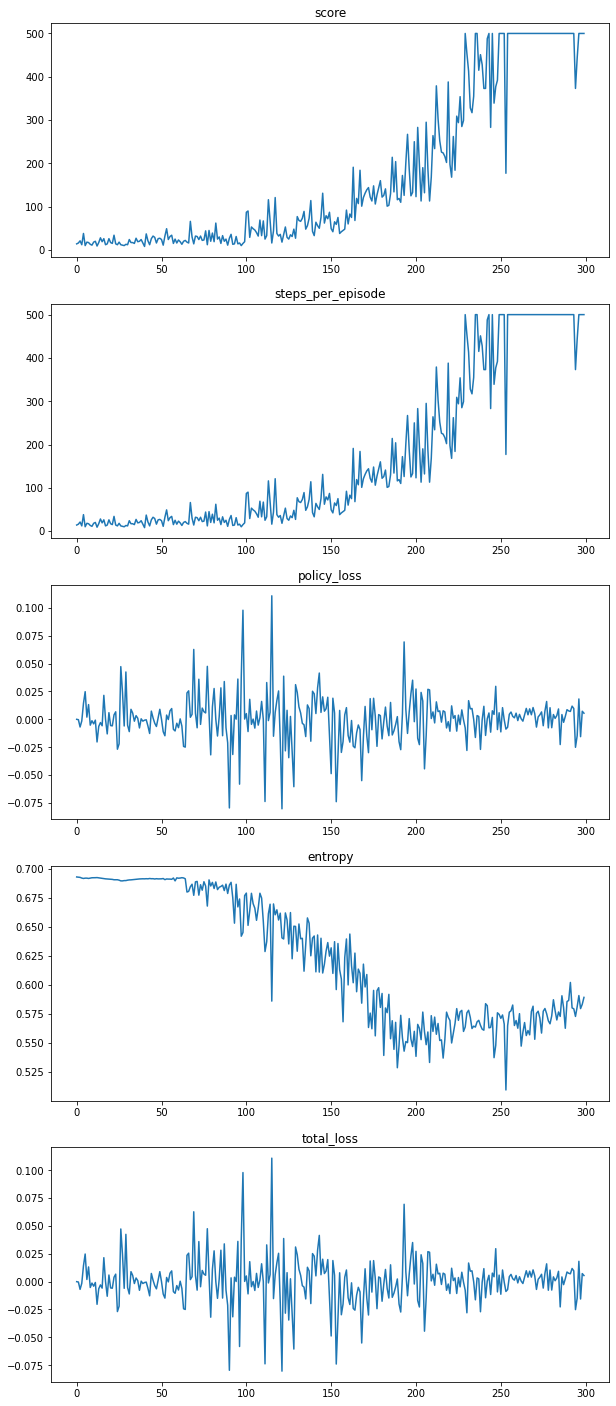

In [23]:
history = agent.run(
    plot_stats=[
        'score',
        'steps_per_episode',
        'policy_loss',
        'entropy',
        'total_loss'
    ], 
    plot_period=50,
    history=history
)

In [24]:
from IPython.display import Video
from os.path import join

from gym.wrappers import Monitor

from policy_gradient.reinforce import run_episode

video_path = join(ROOT_DIR, 'video')
eval_env = Monitor(
    agent.env,
    video_path,
    video_callable=lambda x: True,
    force=True,
)

run_episode(eval_env, agent)

# take the last element in the folder with .mp4 extension
video_name = [x for x in os.listdir(video_path) if '.mp4' in x][-1]
Video(join(video_path, video_name))

## Continuous Cartpole

In [25]:
ROOT_DIR = join("Experiments", "pg_cartpole_continuous")

agent = ReinforceAgent(
    config=dict(
        env_or_env_name=ContinuousCartPoleEnv(),
        logdir=join("Experiments", "pg_cartpole_continuous"),
        use_tensorboard=False,
        explore=True,
        gamma=0.99,
        num_episodes=300,
        num_dim_actor=(32, 32),
        act_f_actor="tanh",
        entropy_coeff=1e-5,
        lr=0.0025,
        clip_gradients_by_norm=None,
        standardize_return=True,
    )
)
history = {}

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


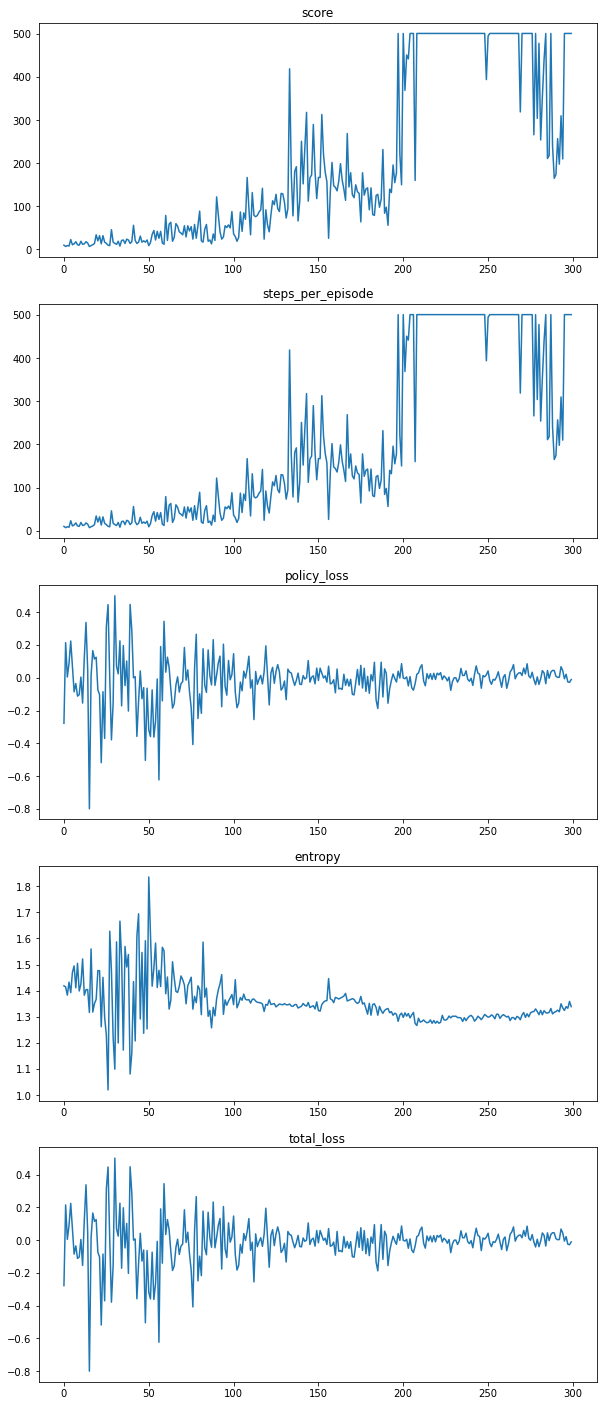

In [26]:
history = agent.run(
    plot_stats=[
        'score',
        'steps_per_episode',
        'policy_loss',
        'entropy',
        'total_loss'
    ], 
    plot_period=50,
    history=history
)

In [27]:
from IPython.display import Video
import os
video_path = join(ROOT_DIR, 'video')
eval_env = Monitor(
    agent.env,
    video_path,
    video_callable=lambda x: True,
    force=True,
)

run_episode(eval_env, agent)

# take the last element in the folder with .mp4 extension
video_name = [x for x in os.listdir(video_path) if '.mp4' in x][-1]
Video(os.path.join(video_path, video_name))

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# LunarLander

In [38]:
ROOT_DIR = join("Experiments", "pg_cartpole_continuous")

agent = ReinforceAgent(
    config=dict(
        env_or_env_name="LunarLanderContinuous-v2",
        logdir=join("Experiments", "pg_lunarlander_continuous"),
        use_tensorboard=False,
        explore=True,
        gamma=0.99,
        num_episodes=2000,
        num_dim_actor=(64, 64, 128),
        act_f_actor="tanh",
        entropy_coeff=1e-5,
        lr=0.0025,
        clip_gradients_by_norm=0.5,
        standardize_return=True,
    )
)
history = {}

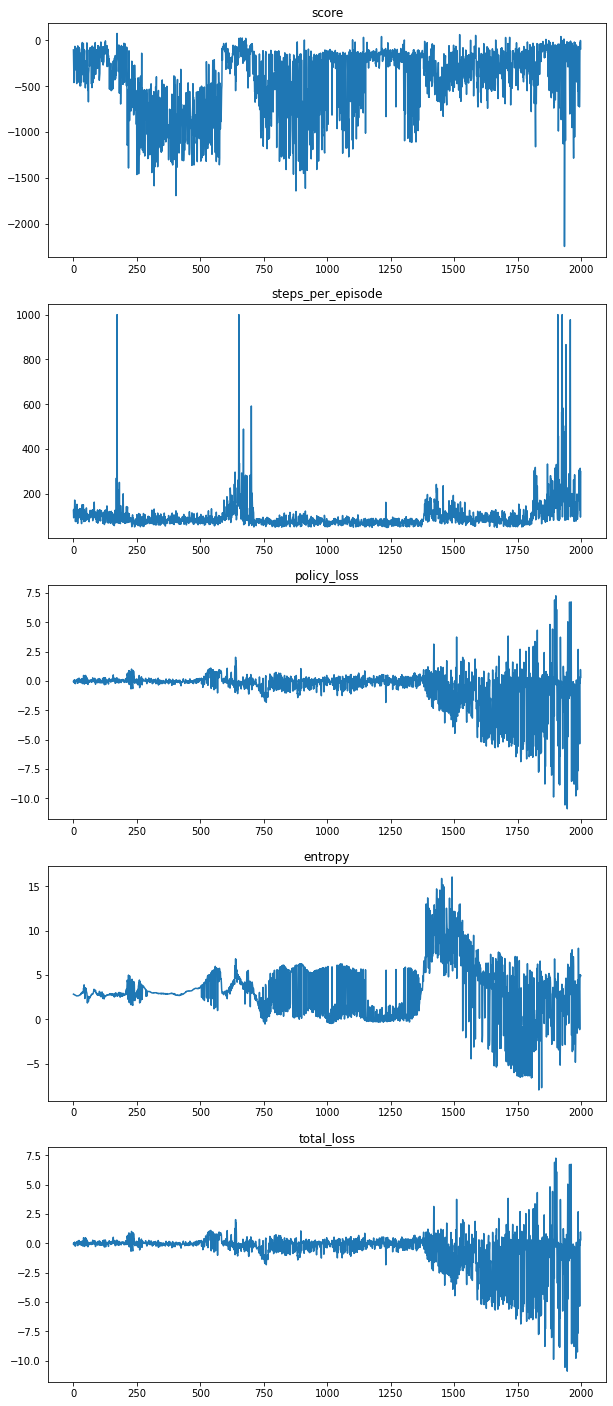

In [39]:
history = agent.run(
    plot_stats=[
        'score',
        'steps_per_episode',
        'policy_loss',
        'entropy',
        'total_loss'
    ], 
    plot_period=50,
    history=history
)

In [20]:
from IPython.display import Video
from os.path import join

from gym.wrappers import Monitor

from policy_gradient.reinforce import run_episode

video_path = join(ROOT_DIR, 'video')
eval_env = Monitor(
    agent.env,
    video_path,
    video_callable=lambda x: True,
    force=True,
)

run_episode(eval_env, agent)

# take the last element in the folder with .mp4 extension
video_name = [x for x in os.listdir(video_path) if '.mp4' in x][-1]
Video(join(video_path, video_name))